# Bass Matching Demo with Colored Notation

This notebook demonstrates the `percent_bass_pc_match` function from `music_df.harmony.matching`,
with **colored notation** to visually highlight which bass notes match their expected pitch classes.

- **Green** bass notes: match the expected bass PC (root position)
- **Red** bass notes: don't match the expected bass PC (inverted)

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

In [2]:
import io

import verovio
from IPython.display import SVG, display
import pandas as pd

from music_df.humdrum_export import df2hum, df_with_harmony_to_hum
from music_df.harmony.matching import percent_bass_pc_match

In [3]:
MATCH_COLOR = "#00AA00"  # Green for matching bass
NO_MATCH_COLOR = "#DD0000"  # Red for non-matching bass


def show_bass_matching(
    result_df: pd.DataFrame,
    chord_df: pd.DataFrame,
    split_degree: bool = False,
    width: int = 1200,
    scale: int = 50,
) -> None:
    """Convert result DataFrame to colored notation and display it."""
    result_df = result_df.copy()
    result_df["color"] = result_df["is_bass_match"].map({True: "match", False: "no_match"})
    result_df["is_bass"] = result_df["is_bass_match"].notna()

    humdrum = df_with_harmony_to_hum(
        result_df,
        chord_df,
        split_degree=split_degree,
        color_col="color",
        color_mask_col="is_bass",
        color_mapping={"match": MATCH_COLOR, "no_match": NO_MATCH_COLOR},
    )

    tk = verovio.toolkit()
    tk.setOptions({"pageWidth": width, "scale": scale, "adjustPageHeight": True})
    tk.loadData(humdrum)
    for page in range(1, tk.getPageCount() + 1):
        display(SVG(tk.renderToSVG(page)))

## Example 1: Root Position Chords (100% bass match)

C major (C-E-G) and G major (G-B-D) triads in root position.
Bass notes C and G match their expected PCs, so they appear **green**.

In [ ]:
music_df1 = pd.read_csv(io.StringIO('''
type,pitch,onset,release,spelling
bar,,0.0,,
note,48,0.0,2.0,C
note,64,0.0,2.0,E
note,67,0.0,2.0,G
note,43,2.0,4.0,G
note,59,2.0,4.0,B
note,62,2.0,4.0,D
bar,,4.0,,
'''))

chord_df1 = pd.read_csv(io.StringIO('''
onset,release,key,degree,quality,inversion,chord_pcs
0.0,2.0,C,I,M,0,047
2.0,4.0,C,V,M,0,72B
'''), dtype={"chord_pcs": str})

result1 = percent_bass_pc_match(music_df1, chord_df1)
print(f"Bass match rate: {result1['microaverage']:.0%}")
show_bass_matching(result1["music_df"], chord_df1)

## Example 2: Inverted Chords (0% bass match)

Same C major and G major chords, but in first inversion.
Bass notes E and B don't match expected PCs (0 and 7), so they appear **red**.

In [ ]:
music_df2 = pd.read_csv(io.StringIO('''
type,pitch,onset,release,spelling
bar,,0.0,,
note,52,0.0,2.0,E
note,60,0.0,2.0,C
note,67,0.0,2.0,G
note,47,2.0,4.0,B
note,62,2.0,4.0,D
note,67,2.0,4.0,G
bar,,4.0,,
'''))

chord_df2 = pd.read_csv(io.StringIO('''
onset,release,key,degree,quality,inversion,chord_pcs
0.0,2.0,C,I,M,0,047
2.0,4.0,C,V,M,0,72B
'''), dtype={"chord_pcs": str})

result2 = percent_bass_pc_match(music_df2, chord_df2)
print(f"Bass match rate: {result2['microaverage']:.0%}")
show_bass_matching(result2["music_df"], chord_df2)

## Example 3: Mixed (Partial match)

First chord in root position (bass matches → green),
second chord inverted (bass doesn't match → red).

In [ ]:
music_df3 = pd.read_csv(io.StringIO('''
type,pitch,onset,release,spelling
bar,,0.0,,
note,48,0.0,2.0,C
note,64,0.0,2.0,E
note,67,0.0,2.0,G
note,47,2.0,4.0,B
note,62,2.0,4.0,D
note,67,2.0,4.0,G
bar,,4.0,,
'''))

chord_df3 = pd.read_csv(io.StringIO('''
onset,release,key,degree,quality,inversion,chord_pcs
0.0,2.0,C,I,M,0,047
2.0,4.0,C,V,M,0,72B
'''), dtype={"chord_pcs": str})

result3 = percent_bass_pc_match(music_df3, chord_df3)
print(f"Bass match rate: {result3['microaverage']:.0%}")
show_bass_matching(result3["music_df"], chord_df3)

## Example 4: Duration Weighting Demo

Two bass notes within a single chord:
- C (matching) held for 3 beats → green
- D (non-matching) held for 1 beat → red

With duration weighting: 3/(3+1) = 75%
Without duration weighting: 1/2 = 50%

In [ ]:
music_df4 = pd.read_csv(io.StringIO('''
type,pitch,onset,release,spelling
bar,,0.0,,
note,48,0.0,3.0,C
note,64,0.0,3.0,E
note,67,0.0,3.0,G
note,50,3.0,4.0,D
note,65,3.0,4.0,F
note,69,3.0,4.0,A
bar,,4.0,,
'''))

chord_df4 = pd.read_csv(io.StringIO('''
onset,release,key,degree,quality,inversion,chord_pcs
0.0,4.0,C,I,M,0,047
'''), dtype={"chord_pcs": str})

result4_weighted = percent_bass_pc_match(music_df4, chord_df4, weight_by_duration=True)
result4_unweighted = percent_bass_pc_match(music_df4, chord_df4, weight_by_duration=False)

print(f"With duration weighting:    {result4_weighted['microaverage']:.0%}")
print(f"Without duration weighting: {result4_unweighted['microaverage']:.0%}")
show_bass_matching(result4_weighted["music_df"], chord_df4)

## Real Music Examples

Now let's apply bass matching to real music from the test resources.

In [8]:
from music_df.read_csv import read_csv as mdf_read_csv

EXAMPLE_DIR = Path("../tests/resources/example_dfs")


def load_first_n_bars(notes_path: Path, chords_path: Path, n_bars: int = 4):
    """Load notes and chords, filter to first n bars."""
    notes_df = mdf_read_csv(str(notes_path)).reset_index()
    chords_df = pd.read_csv(chords_path)

    # Fix time signature values (some CSVs have floats instead of ints)
    ts_mask = notes_df["type"] == "time_signature"
    for idx in notes_df[ts_mask].index:
        other = notes_df.at[idx, "other"]
        if isinstance(other, dict):
            other["numerator"] = int(other["numerator"])
            other["denominator"] = int(other["denominator"])

    # Find bar boundaries
    bars = notes_df[notes_df["type"] == "bar"]["onset"].sort_values()
    if len(bars) > n_bars:
        cutoff = bars.iloc[n_bars]
    else:
        cutoff = notes_df["release"].max()

    # Filter to first n bars
    notes_filtered = notes_df[notes_df["onset"] < cutoff].copy()
    chords_filtered = chords_df[chords_df["onset"] < cutoff].copy()

    return notes_filtered, chords_filtered

Bass match rate: 92%


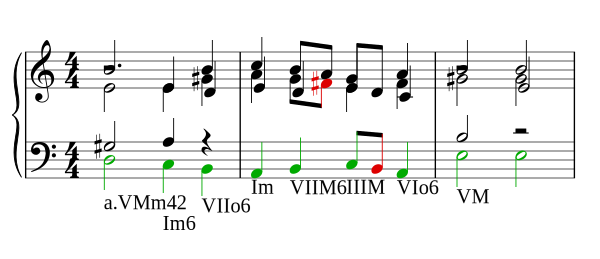

In [9]:
bach_notes, bach_chords = load_first_n_bars(
    EXAMPLE_DIR / "Bach,_Johann_Sebastian_Chorales_010_notes.csv",
    EXAMPLE_DIR / "Bach,_Johann_Sebastian_Chorales_010_chords.csv",
    n_bars=4,
)

result_bach = percent_bass_pc_match(bach_notes, bach_chords)
print(f"Bass match rate: {result_bach['microaverage']:.0%}")
show_bass_matching(result_bach["music_df"], bach_chords, split_degree=True)

Bass match rate: 78%


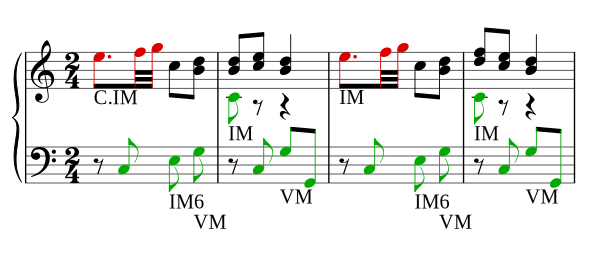

In [10]:
mozart_notes, mozart_chords = load_first_n_bars(
    EXAMPLE_DIR / "K330-3_notes.csv",
    EXAMPLE_DIR / "K330-3_chords.csv",
    n_bars=4,
)

result_mozart = percent_bass_pc_match(mozart_notes, mozart_chords)
print(f"Bass match rate: {result_mozart['microaverage']:.0%}")
show_bass_matching(result_mozart["music_df"], mozart_chords, split_degree=True)

Bass match rate: 41%


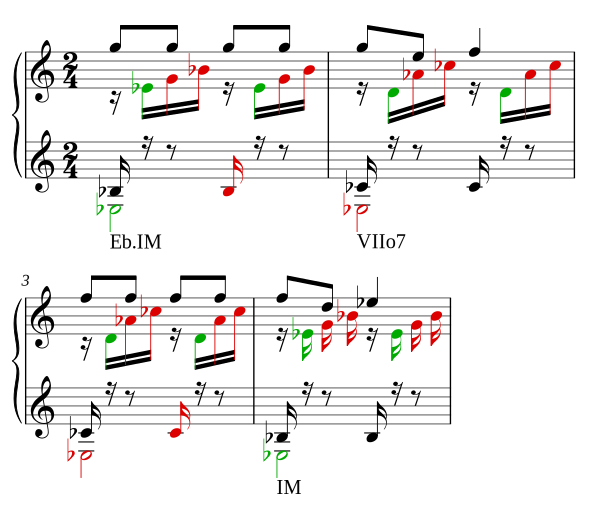

In [11]:
grieg_notes, grieg_chords = load_first_n_bars(
    EXAMPLE_DIR / "op12n01_notes.csv",
    EXAMPLE_DIR / "op12n01_chords.csv",
    n_bars=4,
)

result_grieg = percent_bass_pc_match(grieg_notes, grieg_chords)
print(f"Bass match rate: {result_grieg['microaverage']:.0%}")
show_bass_matching(result_grieg["music_df"], grieg_chords, split_degree=True)